In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

In [12]:
file_path = os.path.join(os.environ.get('prodir'),'waom10_tds_2015.nc')
min_t = xr.open_dataset(file_path)
file_path = os.path.join(os.environ.get('prodir'),'waom10_tds_2024.nc')
max_t = xr.open_dataset(file_path)
file_path = os.path.join(os.environ.get('prodir'),'waom10_tds_2019.nc')
mean_t = xr.open_dataset(file_path)

In [6]:
print(min_t.tidal_constituents.values)

[[b'M' b'S' b'N' b'K' b'K' b'O' b'P' b'Q' b'M' b'M' b'M' b'M' b'M']
 [b'2' b'2' b'2' b'2' b'1' b'1' b'1' b'1' b'F' b'M' b'4' b'S' b'N']
 [b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b'4' b'4']
 [b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ']]


In [30]:
mean_t.tide_Eamp

<xarray.DataArray 'tide_Eamp' (tide_period: 13, eta_rho: 530, xi_rho: 630)>
[4340700 values with dtype=float64]
Coordinates:
  * tide_period  (tide_period) timedelta64[ns] 0 days 12:25:14.163600 ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  tidal elevation amplitude
    units:      meter
    field:      tide_Eamp, scalar

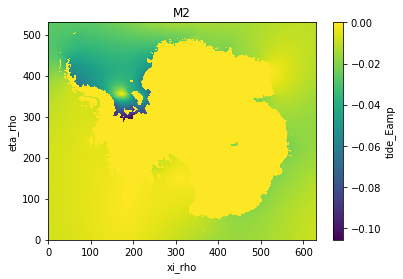

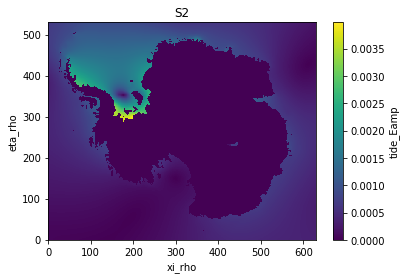

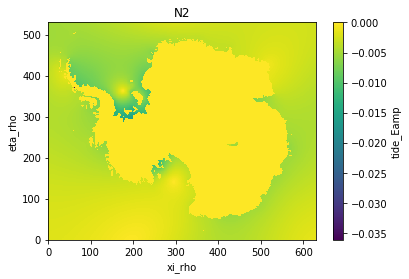

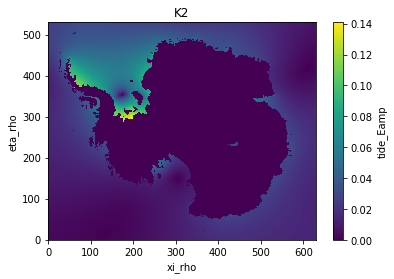

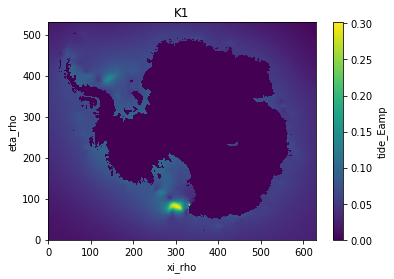

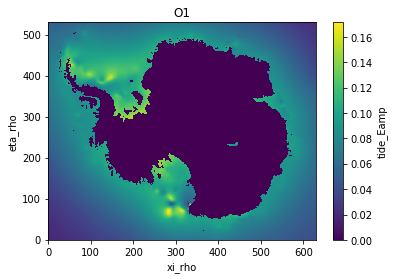

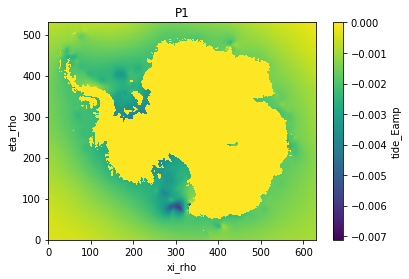

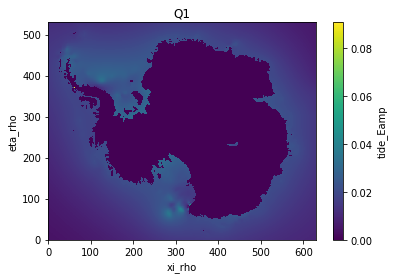

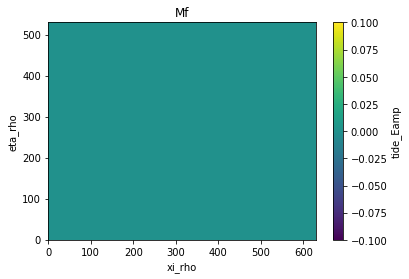

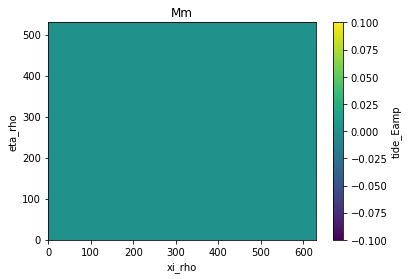

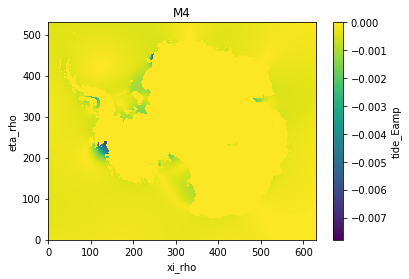

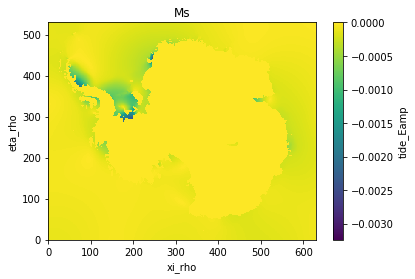

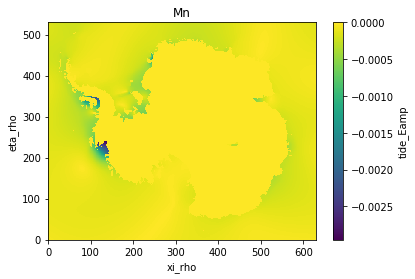

In [33]:
plt.close()
for ind,const in enumerate(['M2','S2','N2','K2','K1','O1','P1','Q1','Mf','Mm','M4','Ms','Mn']):
    (max_t.tide_Eamp[ind] - min_t.tide_Eamp[ind]).plot()
    plt.title(const)
    plt.show()

In [1]:
# analysis

In [5]:
#load data
file_path = os.path.join(os.environ.get('rawdir'),'waom10_nodal','ocean_avg_2015_0004.nc')
low = xr.open_dataset(file_path)

file_path = os.path.join(os.environ.get('rawdir'),'waom10_nodal','ocean_avg_2019_0004.nc')
mid = xr.open_dataset(file_path)

file_path = os.path.join(os.environ.get('rawdir'),'waom10_nodal','ocean_avg_2024_0004.nc')
high = xr.open_dataset(file_path)

grid_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_grd.nc')
grd = xr.open_dataset(grid_path)

In [6]:
low

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_psi: 529, eta_rho: 530, eta_u: 530, eta_v: 529, ocean_time: 12, s_rho: 31, s_w: 32, tracer: 2, xi_psi: 629, xi_rho: 630, xi_u: 629, xi_v: 630)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 -0.8871 -0.8548 ...
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 -0.9032 -0.871 -0.8387 ...
    x_rho          (eta_rho, xi_rho) float64 ...
    y_rho          (eta_rho, xi_rho) float64 ...
    x_u            (eta_u, xi_u) float64 ...
    y_u            (eta_u, xi_u) float64 ...
    x_v            (eta_v, xi_v) float64 ...
    y_v            (eta_v, xi_v) float64 ...
    x_psi          (eta_psi, xi_psi) float64 ...
    y_psi          (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2018-01-15T05:00:00 ...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes         int32 ...
    ndtfast        int32 ...


In [10]:
#convert melt rate from m_water/second into m_ice/years
w2i = 1025/917
s2a = 3600*24*365

for ds in [low,mid,high]:
    ds['m']=ds.m*s2a*w2i

In [11]:
#calculate area integrated annual mean melt rate for both cases and their difference
dA = 1/(grd.pm*grd.pn)
rho0 = 1025

for ds in [low,mid,high]:
    total_m = (ds.m.mean('ocean_time').where((grd.zice < 0.0)&(grd.mask_rho==1))*dA*rho0*(10**-12)).sum()
    ds["total_m"] = xr.DataArray(total_m,dims=[])

In [15]:
((high.total_m-low.total_m)/low.total_m*100).values

array(1.165895997496919)

<IPython.core.display.Javascript object>


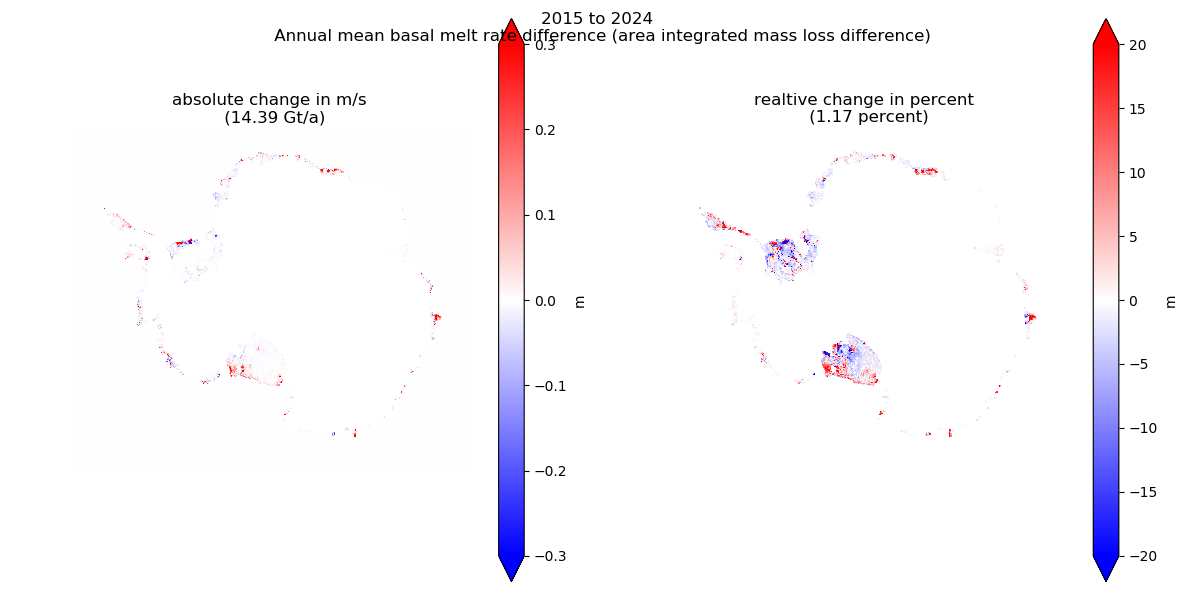

In [19]:
#plot annual average melt rate and integrated mass loss of no_tides and tides case
%matplotlib notebook
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(12,6))
ax1,ax2 = axes.flatten()
fig.suptitle('2015 to 2024 \n Annual mean basal melt rate difference (area integrated mass loss difference)')

(high.m.mean("ocean_time") - low.m.mean('ocean_time')).plot(cmap=plt.cm.bwr,ax=ax1,vmin=-0.3,vmax=0.3)
ax1.set_title('absolute change in m/s \n (%.2f Gt/a)' %(high.total_m-low.total_m).values)

((high.m.mean("ocean_time") - low.m.mean('ocean_time'))/low.m.mean('ocean_time')*100).plot(cmap=plt.cm.bwr,ax=ax2,vmin=-20,vmax=20)
ax2.set_title('realtive change in percent \n (%.2f percent)' %((high.total_m-low.total_m)/low.total_m*100).values)

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
  
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


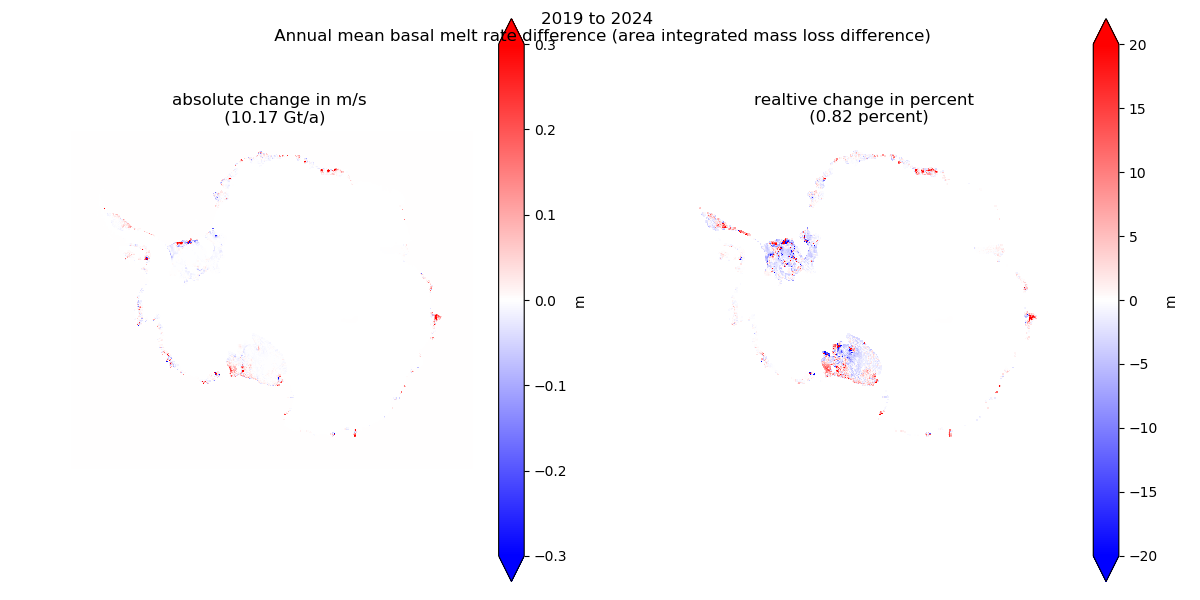

In [20]:
%matplotlib notebook
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(12,6))
ax1,ax2 = axes.flatten()
fig.suptitle('2019 to 2024 \n Annual mean basal melt rate difference (area integrated mass loss difference)')

(high.m.mean("ocean_time") - mid.m.mean('ocean_time')).plot(cmap=plt.cm.bwr,ax=ax1,vmin=-0.3,vmax=0.3)
ax1.set_title('absolute change in m/s \n (%.2f Gt/a)' %(high.total_m-mid.total_m).values)

((high.m.mean("ocean_time") - mid.m.mean('ocean_time'))/low.m.mean('ocean_time')*100).plot(cmap=plt.cm.bwr,ax=ax2,vmin=-20,vmax=20)
ax2.set_title('realtive change in percent \n (%.2f percent)' %((high.total_m-mid.total_m)/mid.total_m*100).values)

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
  
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


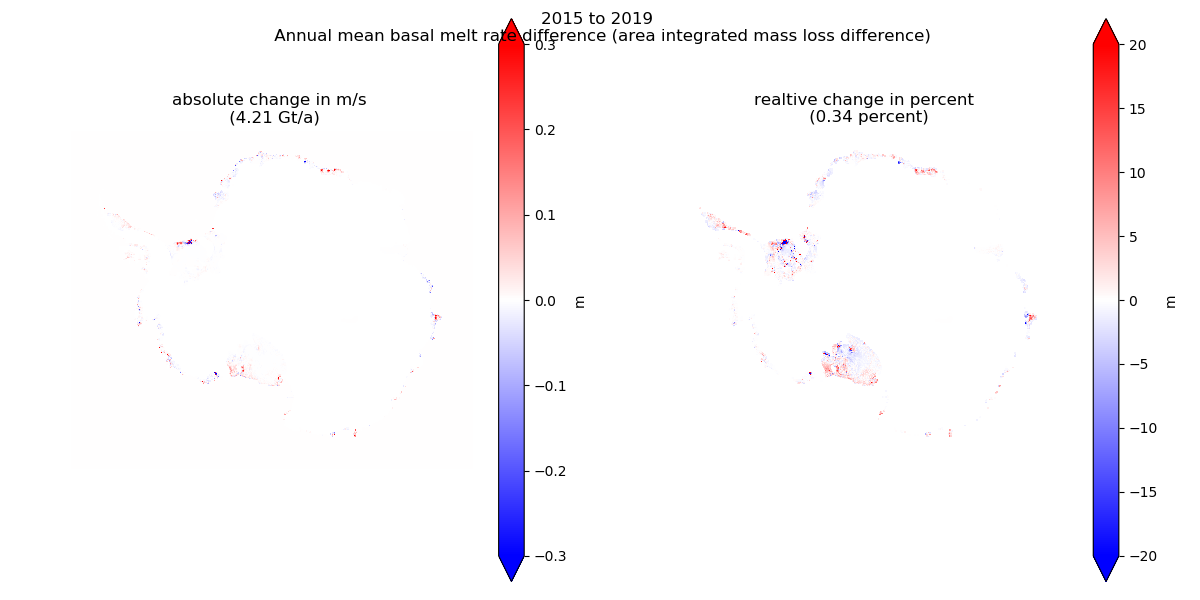

In [23]:
%matplotlib notebook
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(12,6))
ax1,ax2 = axes.flatten()
fig.suptitle('2015 to 2019 \n Annual mean basal melt rate difference (area integrated mass loss difference)')

(mid.m.mean("ocean_time") - low.m.mean('ocean_time')).plot(cmap=plt.cm.bwr,ax=ax1,vmin=-0.3,vmax=0.3)
ax1.set_title('absolute change in m/s \n (%.2f Gt/a)' %(mid.total_m-low.total_m).values)

((mid.m.mean("ocean_time") - low.m.mean('ocean_time'))/low.m.mean('ocean_time')*100).plot(cmap=plt.cm.bwr,ax=ax2,vmin=-20,vmax=20)
ax2.set_title('realtive change in percent \n (%.2f percent)' %((mid.total_m-low.total_m)/low.total_m*100).values)

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')
  
plt.tight_layout()

plt.show()